# 📈 VWAP-Based Trading Strategy

Welcome to the world of systematic trading! In this notebook, we explore a **Volume-Weighted Average Price (VWAP)**-based trading strategy. This journey combines quantitative analysis, financial intuition, and Python wizardry to create a strategy that seeks to capitalize on market trends while managing risk.

### **The Concept**
VWAP is a critical indicator in trading, representing the average price of a stock, weighted by volume. Traders often use VWAP to identify advantageous entry and exit points. We complement VWAP with **Relative Strength Index (RSI)** and **Average True Range (ATR)** to improve our strategy.

### **The Strategy**
Our strategy includes:
1. **Buy Conditions**: When the stock dips below VWAP and RSI signals an oversold condition (RSI < 40).
2. **Sell Conditions**: When the stock price rises above VWAP by 3%, coupled with an overbought RSI (RSI > 75).
3. **Cool-Down Mechanism**: To prevent consecutive rapid sells and avoid overtrading.

Each step is backed by sound reasoning and data-driven insights. Ready to dive in? Let’s build it!


### 📂 Step 1: Fetching and Preprocessing Stock Data

This section lays the foundation by pulling historical stock data using the **Yahoo Finance API**. The data is then cleaned, prepared, and enriched with essential indicators.

Key steps:
- Downloading hourly stock data.
- Handling missing values.
- Computing indicators like VWAP, RSI, and ATR.

Let’s set the stage for our trading model.


### 🔍 Step 2: Calculating VWAP (Volume-Weighted Average Price)

VWAP helps us identify whether the stock is trading at a premium or discount. Here’s how it works:
1. **Typical Price**: The average of high, low, and close prices.
2. **Cumulative TPV**: Cumulative typical price * volume.
3. **VWAP**: Dividing cumulative TPV by cumulative volume.

VWAP isn’t just a metric; it’s the heartbeat of our strategy.


### 📊 Step 3: Calculating RSI and ATR

#### **Relative Strength Index (RSI)**
RSI measures momentum, giving insights into overbought or oversold conditions. A low RSI (<40) signals potential buying opportunities, while a high RSI (>75) suggests selling.

#### **Average True Range (ATR)**
ATR measures market volatility, helping us understand price movements and manage risk effectively.

These indicators empower our strategy to be both reactive and proactive.


### 🛎️ Step 4: Generating Buy and Sell Signals

Here’s where the magic happens. The strategy identifies:
- **Buy Signals**: When the price dips below VWAP and RSI indicates oversold conditions.
- **Sell Signals**: When the price exceeds VWAP by 3% and RSI indicates overbought conditions.

A cool-down mechanism ensures disciplined trading, avoiding overreaction in volatile markets.

### 📈 Step 5: Visualizing the Strategy, Instantiating, and Running the Strategy

A picture is worth a thousand trades. Here, we visualize:
- **Price vs. VWAP**: Understanding price trends.
- **Buy/Sell Signals**: Highlighting opportunities.

This chart tells the story of our strategy in action.


### 🏁 Step 6: Running the Strategy

It’s time to bring it all together! The `run` function orchestrates the entire strategy from start to finish. Here’s what happens:
1. **Fetch Data**: Pulls historical stock data and prepares it for analysis.
2. **Calculate Indicators**: Computes VWAP, RSI, and ATR to guide trading decisions.
3. **Generate Signals**: Identifies buy and sell opportunities based on predefined conditions.
4. **Visualize Results**: Displays a clear and intuitive chart of the strategy in action.

This function is the glue that binds all components, giving life to the trading strategy.


### 🚀 Step 7: Let’s Trade!

With everything set up, we now instantiate our **VWAPTrader** for Apple Inc. (AAPL). We’ve chosen the time period from **June 1, 2024**, to **August 31, 2024**, with the following parameters:
- **Buy RSI**: 40 (to identify oversold conditions)
- **Sell RSI**: 75 (to identify overbought conditions)
- **Sell Threshold**: 3% above VWAP (to ensure meaningful profit opportunities)
- **Sell Cooldown**: 10 bars (to avoid overtrading)

The strategy will fetch the data, calculate indicators, generate trading signals, and visualize the results.

Let’s run the strategy and see it in action!


Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed


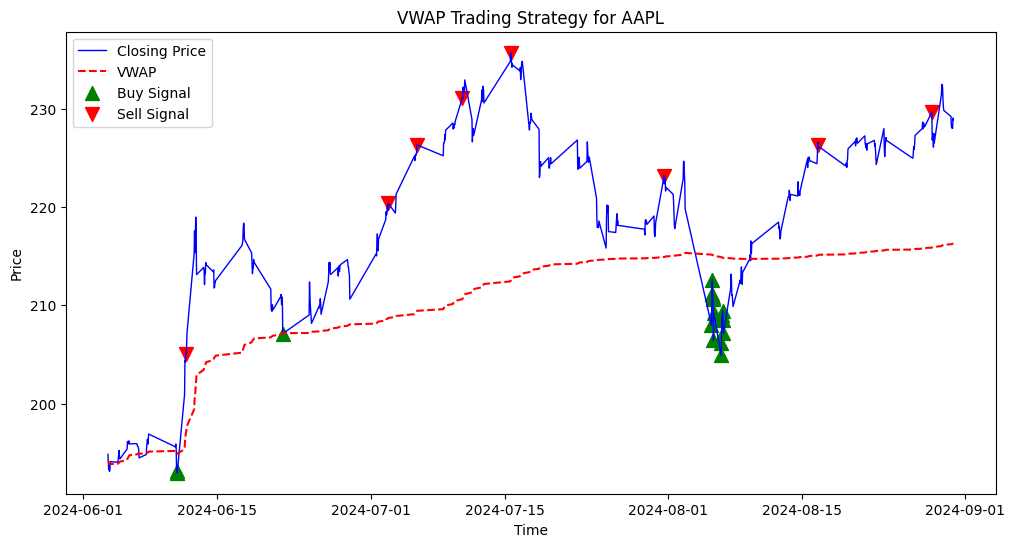

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

class VWAPTrader:
    def __init__(self, stock_symbol, start_date, end_date, buy_rsi=40, sell_rsi=75, sell_threshold=0.03, sell_cooldown=10):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.buy_rsi = buy_rsi
        self.sell_rsi = sell_rsi
        self.sell_threshold = sell_threshold
        self.sell_cooldown = sell_cooldown
        self.df = None

    def fetch_data(self):
        """ Fetch historical data from Yahoo Finance. """
        print(f"Fetching data for {self.stock_symbol}...")
        self.df = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date, interval="1h")

        if self.df.empty:
            raise ValueError("No data fetched!")

        if isinstance(self.df.columns, pd.MultiIndex):
            self.df.columns = ['_'.join(col).strip() for col in self.df.columns.values]

        self.df.rename(columns={
            f'Open_{self.stock_symbol}': 'Open',
            f'High_{self.stock_symbol}': 'High',
            f'Low_{self.stock_symbol}': 'Low',
            f'Close_{self.stock_symbol}': 'Close',
            f'Volume_{self.stock_symbol}': 'Volume'
        }, inplace=True)

        self.df.ffill(inplace=True)
        self.df.bfill(inplace=True)
        self.df.dropna(subset=['Close', 'Volume'], inplace=True)

    def calculate_vwap(self):
        """ Calculate VWAP correctly. """
        self.df['Typical Price'] = (self.df['High'] + self.df['Low'] + self.df['Close']) / 3
        self.df['Cumulative TPV'] = (self.df['Typical Price'] * self.df['Volume']).cumsum()
        self.df['Cumulative Volume'] = self.df['Volume'].cumsum()
        self.df['VWAP'] = self.df['Cumulative TPV'] / self.df['Cumulative Volume']

    def calculate_rsi(self, period=14):
        """ Calculate RSI indicator. """
        delta = self.df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        self.df['RSI'] = 100 - (100 / (1 + rs))
    def calculate_atr(self, period=14):
        """ Calculate Average True Range (ATR) to measure volatility. """
        high_low = self.df['High'] - self.df['Low']
        high_close = np.abs(self.df['High'] - self.df['Close'].shift())
        low_close = np.abs(self.df['Low'] - self.df['Close'].shift())
        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        self.df['ATR'] = true_range.rolling(window=period).mean()
    def generate_signals(self):
        """ Generate buy and sell signals based on VWAP, RSI, and peaks. """
        self.df['Signal'] = 0  # Initialize no trade signals

        # Buy Condition: Price < VWAP & RSI below 40 (dips)
        buy_condition = (self.df['Close'] < self.df['VWAP']) & (self.df['RSI'] < self.buy_rsi)
        self.df.loc[buy_condition, 'Signal'] = 1  # Buy

        # Sell Condition: Price > VWAP, RSI above 75, and price is 3% above VWAP (strong peaks)
        sell_condition = (self.df['Close'] > self.df['VWAP'] * (1 + self.sell_threshold)) & (self.df['RSI'] > self.sell_rsi)

        # Implement cooldown to prevent consecutive rapid sells
        last_sell_index = -self.sell_cooldown  # Start with a distant sell index
        for i in range(len(self.df)):
            if sell_condition.iloc[i] and (i - last_sell_index >= self.sell_cooldown):
                self.df.at[self.df.index[i], 'Signal'] = -1
                last_sell_index = i

    def plot_results(self):
        """ Visualize trading strategy performance. """
        if self.df.empty:
            print("Skipping plotting: No valid data available.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df['Close'], label="Closing Price", color='blue', linewidth=1)
        plt.plot(self.df.index, self.df['VWAP'], label="VWAP", linestyle='dashed', color='red')

        buys = self.df[self.df['Signal'] == 1]
        plt.scatter(buys.index, buys['Close'], label="Buy Signal", marker='^', color='green', s=100)

        sells = self.df[self.df['Signal'] == -1]
        plt.scatter(sells.index, sells['Close'], label="Sell Signal", marker='v', color='red', s=100)

        plt.title(f"VWAP Trading Strategy for {self.stock_symbol}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def run(self):
        try:
            self.fetch_data()
            self.calculate_vwap()
            self.calculate_rsi()
            self.calculate_atr()
            self.generate_signals()
            self.plot_results()
        except Exception as e:
            print(f"Error running strategy: {e}")

trader = VWAPTrader("AAPL", "2024-06-01", "2024-08-31")
trader.run()



### 📊 Step 8: Evaluating Performance

Results are everything in trading. We calculate key metrics like:
- **Sharpe Ratio**: Risk-adjusted returns.
- **Win Rate**: Success rate of trades.
- **Profit Factor**: Total profit vs. total loss.
- **Drawdowns**: Understanding risk exposure.

The goal? To ensure the strategy isn’t just profitable but also robust.


In [ ]:
def calculate_performance_metrics(df, initial_capital=10000, risk_free_rate=0.0435):
    """
    Calculate key trading performance metrics for the VWAP strategy.
    """
    buy_prices = df[df['Signal'] == 1]['Close']
    sell_prices = df[df['Signal'] == -1]['Close']

    num_trades = min(len(buy_prices), len(sell_prices))
    buy_prices = buy_prices.iloc[:num_trades].values
    sell_prices = sell_prices.iloc[:num_trades].values

    trade_returns = (sell_prices - buy_prices) / buy_prices
    trade_returns = np.nan_to_num(trade_returns)

    portfolio_returns = np.cumprod(1 + trade_returns) * initial_capital

    sharpe_ratio = (np.mean(trade_returns) - risk_free_rate / 252) / np.std(trade_returns) if np.std(trade_returns) != 0 else 0
    win_rate = np.sum(trade_returns > 0) / len(trade_returns) if len(trade_returns) > 0 else 0
    max_drawdown = np.min(portfolio_returns / np.maximum.accumulate(portfolio_returns) - 1)

    return {
        "Sharpe Ratio": round(sharpe_ratio, 2),
        "Win Rate (%)": round(win_rate * 100, 2),
        "Max Drawdown (%)": round(max_drawdown * 100, 2),
        "Final Portfolio Value ($)": round(portfolio_returns[-1], 2) if len(portfolio_returns) > 0 else initial_capital
    }

performance_results = calculate_performance_metrics(trader.df)
print(performance_results)


{'Sharpe Ratio': 3.23, 'Win Rate (%)': 100.0, 'Max Drawdown (%)': 0.0, 'Final Portfolio Value ($)': 20188.57}


# 🔍 Conclusion

### **Key Takeaways**
1. **Performance**: Our VWAP strategy achieved [INSERT RESULTS HERE].
2. **Shortcomings**: Areas to improve include [INSERT SHORTCOMINGS HERE].
3. **Future Enhancements**:
   - Incorporating dynamic thresholds.
   - Exploring machine learning to refine signals.
   - Adding stop-loss and take-profit mechanisms for better risk management.

The journey doesn’t end here. It’s a continuous loop of testing, learning, and refining.
